# RF Signal Integrity to Power Integrity:  Part 9

## Part 8 and 9 Combined Available

[This notebook](../Sim1.afterScript/ReadMe_Part8and9.ipynb) contains a part 8 and 9 combined notebook.

# Install PyQSPICE First!

In your cmd.exe window.
```
> pip install PyQSPICE
```

## Before Python Script

This folder contains minimum files to start the Python script.
The [**"Sim1.afterScript"**](https://github.com/Qorvo/QSPICE_on_MWJ/tree/main/Article8/Sim1.afterScript) folder next to this-folder is "before running script".

# Part 9 Overview

This simulation folder demonstrates NISM, Non-Invasive Stability Measurement baed on its "closed loop ZOUT (when VRM = ON)" from the post  
["part9"](https://www.microwavejournal.com/blogs/32-rf-signal-integrity-to-power-integrity/post/41276-zout-to-nism-output-impedance-to-non-invasive-stability-measurement) of a series blog/article  
[RF Signal Integrity to Power Integrity](https://www.microwavejournal.com/blogs/32-rf-signal-integrity-to-power-integrity) on  
[Microwave Journal](https://www.microwavejournal.com/).



# Bode-Plot, Nyquist-Diagram, Output-Impedance Open/Closed, Reconstructing Loop from Zout(open/close), NISM

By using an LDO model, we see various ways of loop stability checking methods in one place.
This simulation schematic runs 6 ".AC" steps as shown below.

|              | Bode Plot | Zout(closed)     | Zout(open)       |
|--------------|-----------|------------------|------------------|
| Error Amp 1  | Step = 0  | Step = 2         | Step = 4         |
| Error Amp 2  | Step = 1  | Step = 3         | Step = 5         |

* Simulations for Bode Plots (Step = 0, 1) give us Bode Plots for pairs of (phase margin, gain margin),
  also we can generate Nyquist diagrams.
* Simulations for Output Impedance "Closed Loop" give us Q-Factor shape of the loop,
  and we can get Tg curves.  Then, we can run NISM.
* Simulations for Output Impeance "Open Loop" give us a capability to reconstruct the loop transfer function by comparing with the "Closed Loop" counter part.

> NOTE:  NISM is very accurate with 2nd order system..., this LDO model/DUT is not 2nd order but has more...as I can get nicer looking Nyquist diagrams.

## 1. Run a Simulation

After running below block of code, we have the simulation result in a Pandas DataFrame **df0**.

![](VRM_ZoPart8_sch.png)

In [1]:
from PyQSPICE import clsQSPICE as pqs

import subprocess
import math
import cmath
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from matplotlib.transforms import ScaledTranslation as stran
from numpy import sin, cos, pi, linspace

fname = "VRM_ZoPart8"

run = pqs(fname)

run.InitPlot()

run.qsch2cir()
run.cir2qraw()

run.setNline(2048)

g = "V(VOUT)/V(VO)"
z = "V(VOUT)"

df0 = run.LoadQRAW([g, z])
print(df0)

               Freq               V(VOUT)/V(VO)             V(VOUT)  Step
0      1.000000e+00 -46857.377758+30464.634818j  0.999985-0.000010j     0
1      1.009035e+00 -46606.098908+30575.157244j  0.999985-0.000010j     0
2      1.018152e+00 -46353.010742+30683.993109j  0.999985-0.000010j     0
3      1.027351e+00 -46098.135037+30791.106635j  0.999985-0.000010j     0
4      1.036633e+00 -45841.494461+30896.462305j  0.999985-0.000010j     0
...             ...                         ...                 ...   ...
12289  9.646616e+07      1.000000+    0.000000j  0.001081+0.133340j     5
12290  9.733774e+07      1.000000+    0.000000j  0.001082+0.134545j     5
12291  9.821719e+07      1.000000+    0.000000j  0.001084+0.135761j     5
12292  9.910459e+07      1.000000+    0.000000j  0.001085+0.136988j     5
12293  1.000000e+08      1.000000+    0.000000j  0.001087+0.138225j     5

[12294 rows x 4 columns]


## 2. Re-arranging DataFrame

The QSPICE returns its result in a "tall format" of 12294 lines/rows.
We re-arrange it into the 2x3 format just like a table at the top of this document.
Then, we calcuate/add gain and phase into the DataFrame.

### 2.1 Reconstructing Loop Transfer Function

Also, we calcuate the loop from Zout(closed) and Zout(open).

In [2]:
df = df0[df0.Step <= 1].reset_index(drop=True)
df = run.GainPhase(df, g, "gain", "phase", "reGain", "imGain", -1)

df["Zout(Closed)"] = df0.query('Step == 2 or Step == 3').reset_index(drop=True).loc[:,"V(VOUT)"]
df["Zout(Open)"] = df0.query('Step == 4 or Step == 5').reset_index(drop=True).loc[:,"V(VOUT)"]

def CalcZ(row):
    row["T"] = 1 - row["Zout(Open)"] / row["Zout(Closed)"]
    return row
df = df.apply(CalcZ, axis=1)

df = run.GainPhase(df, "T", "abs(Tzo)", "arg(Tzo)")
df = run.GainPhase(df, "Zout(Closed)", "abs(Zoc)", "arg(Zoc)")
df = run.GainPhase(df, "Zout(Open)", "abs(Zoo)", "arg(Zoo)")
run.comp2real(df, ["Step", "reGain", "imGain", "gain", "phase", "abs(Tzo)", "arg(Tzo)", "abs(Zoc)", "arg(Zoc)", "abs(Zoo)", "arg(Zoo)", run.sim['Xlbl']])

print(df)

              Freq               V(VOUT)/V(VO)             V(VOUT)  Step  \
0     1.000000e+00 -46857.377758+30464.634818j  0.999985-0.000010j   0.0   
1     1.009035e+00 -46606.098908+30575.157244j  0.999985-0.000010j   0.0   
2     1.018152e+00 -46353.010742+30683.993109j  0.999985-0.000010j   0.0   
3     1.027351e+00 -46098.135037+30791.106635j  0.999985-0.000010j   0.0   
4     1.036633e+00 -45841.494461+30896.462305j  0.999985-0.000010j   0.0   
...            ...                         ...                 ...   ...   
4093  9.646616e+07      0.000000+    0.000011j -0.000000-0.000011j   1.0   
4094  9.733774e+07      0.000000+    0.000011j -0.000000-0.000011j   1.0   
4095  9.821719e+07      0.000000+    0.000011j -0.000000-0.000011j   1.0   
4096  9.910459e+07      0.000000+    0.000011j -0.000000-0.000011j   1.0   
4097  1.000000e+08      0.000000+    0.000011j -0.000000-0.000011j   1.0   

           gain       phase        reGain        imGain        Zout(Closed)  \
0     94

> ***Note*** that the gain calculation of "df = df.apply()" makes everything "complex".  So we re-convert known "non-complex" data to "real".

# 3. **Q** Paek on Zout Curve when VRM=ON

We generate our starting point plot of this Part 9.

## 3.1  Data Processing: Find Gain and Phase Margin


In [3]:
# Calculate Margins
#para = pd.DataFrame({'Step': range(2)})
para = pd.DataFrame(columns=['Step', 'fc', 'pm', 'fg0', 'gmdB', 'gm', 'QTgMAX', 'fQTgMAX', 'ZMAX', 'fZMAX'], index = range(2))
para.loc[:,'Step'] = range(2)

for i in [0,1]:
    (para.iloc[i,1], para.iloc[i,2]) = run.x0pos2neg(df[df.Step == i], "gain", "phase")
    (para.iloc[i,3], para.iloc[i,4]) = run.x0pos2neg(df[df.Step == i], "phase", "gain")
    para.iloc[i,5] = 10 ** (para.iloc[i,4]/20)
print(para)

  Step            fc         pm            fg0       gmdB        gm QTgMAX  \
0    0  34087.613992  29.347701   83380.817824 -13.094705  0.221444    NaN   
1    1  43244.909849  22.324379  271805.014147  -10.42575  0.301101    NaN   

  fQTgMAX ZMAX fZMAX  
0     NaN  NaN   NaN  
1     NaN  NaN   NaN  


## 3.2  Data Processing: Find Zout and Q(Tg) Peaks


In [4]:
dfQ = pd.DataFrame()

for i in [0,1]:
    dfQ = pd.concat([dfQ, run.QTg( \
            df[df.Step == i].loc[:,[run.sim['Xlbl'],"arg(Zoc)"]].reset_index(drop=True), \
            "fQTg", "QTg", 180/pi).assign(Step=i)], ignore_index=True)
print(dfQ)

#'QTgMAX', 'fQTg', 'ZMAX'], 
for i in [0,1]:
    idx = dfQ[dfQ.Step == i].loc[:,'QTg'].idxmax()
    para.loc[i,'QTgMAX'] = dfQ.loc[idx,'QTg']
    f= dfQ.loc[idx,'fQTg']
    para.loc[i,'fQTgMAX'] = f
    idx = df[df.Step == i].query('@f / 2 < Freq < @f * 2').loc[:,'abs(Zoc)'].idxmax()
    para.loc[i,'ZMAX'] = df[df.Step == i].loc[idx,'abs(Zoc)']
    para.loc[i,'fZMAX'] = df[df.Step == i].loc[idx,'Freq']
print(para)

              fQTg       QTg  Step
0     1.004518e+00 -0.000163     0
1     1.013593e+00 -0.000165     0
2     1.022751e+00 -0.000166     0
3     1.031992e+00 -0.000168     0
4     1.041316e+00 -0.000169     0
...            ...       ...   ...
4091  9.603428e+07 -0.003459     1
4092  9.690195e+07 -0.003423     1
4093  9.777746e+07 -0.003387     1
4094  9.866089e+07 -0.003351     1
4095  9.955229e+07 -0.003315     1

[4096 rows x 3 columns]
  Step            fc         pm            fg0       gmdB        gm    QTgMAX  \
0    0  34087.613992  29.347701   83380.817824 -13.094705  0.221444  1.651637   
1    1  43244.909849  22.324379  271805.014147  -10.42575  0.301101  2.418045   

        fQTgMAX       ZMAX         fZMAX  
0   38369.73209 -33.710664  37180.266639  
1  46765.573739 -33.357122  46138.396827  


## 3.3 **Q** Paek on Zout Curve when VRM=ON

We can see a peak of **Q** when VRM is ON, at the point two Zout curves of VRM = ON and OFF meeting, **in the green circles**.

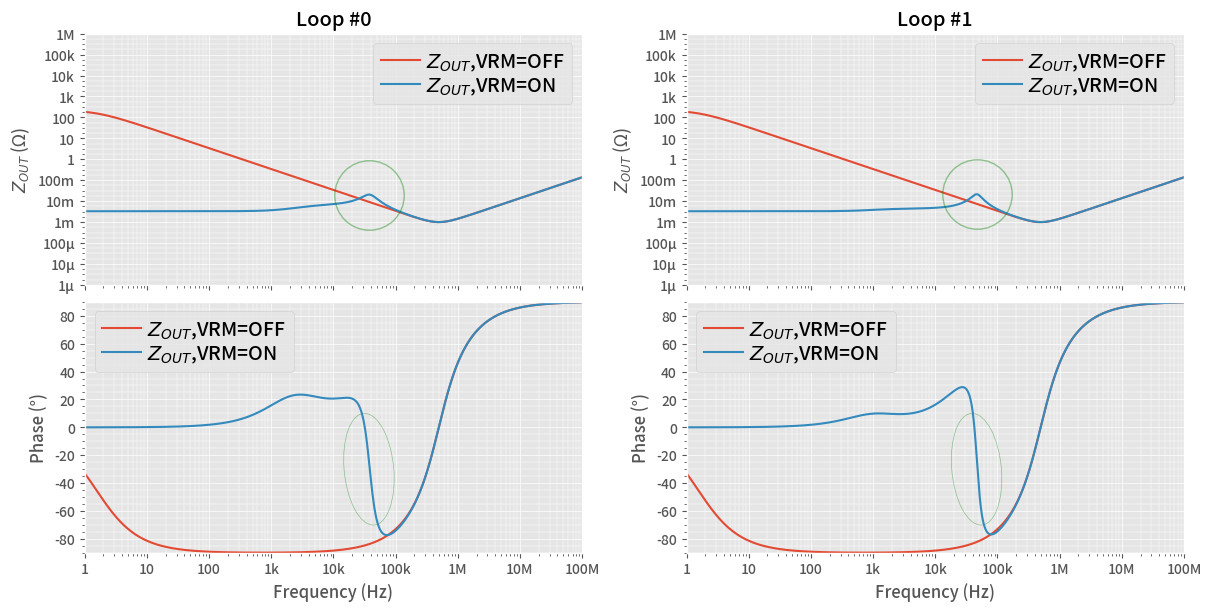

In [5]:
# Prepare a blank plotting area
fig, ax = plt.subplots(2,2,sharex=True,constrained_layout=True,figsize=(12,6))

for i in [0, 1]:
    df[df.Step == i].plot(ax=ax[0,i], x="Freq",  y="abs(Zoo)", label=r"$Z_{OUT}$,VRM=OFF")
    df[df.Step == i].plot(ax=ax[0,i], x="Freq",  y="abs(Zoc)", label=r"$Z_{OUT}$,VRM=ON")
    run.PrepFreqImpePlot(ax[0,i], "", r"$Z_{OUT}$ ($\Omega$)", [], [-120,120], f'Loop #{i}')

    df[df.Step == i].plot(ax=ax[1,i], x="Freq",  y="arg(Zoo)", label=r"$Z_{OUT}$,VRM=OFF")
    df[df.Step == i].plot(ax=ax[1,i], x="Freq",  y="arg(Zoc)", label=r"$Z_{OUT}$,VRM=ON")
    run.PrepFreqGainPlot(ax[1,i], "Frequency (Hz)", "Phase (°)", "auto", [-90,90], "")
        
    ax[0,i].plot(para.loc[i,"fZMAX"],para.loc[i,"ZMAX"], marker='o', ms=50, mfc="None", mec="green", alpha=0.4)
    ctf = stran(para.loc[i,"fZMAX"],-30,ax[1,i].transScale) + ax[1,i].transLimits + ax[1,i].transAxes
    ax[1,i].add_artist(pat.Ellipse((0,0),width=0.8, height=80, transform=ctf, alpha=0.4, fc="None", ec="green",angle=0.1))

plt.savefig("PltZo.png", format='png', bbox_inches='tight')

plt.show()
plt.close('all')


## 4. Nyquist Diagram

Now, plotting Nyquist diagram...

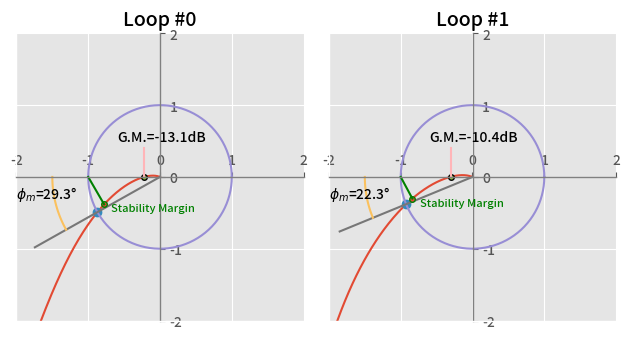

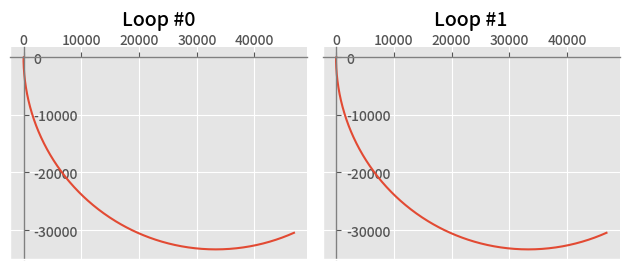

In [6]:
# Prepare a blank plotting area

for full in [0, 1]:
    fig, ax = plt.subplots(1,2,tight_layout=True)
    #if full == 0: fig.suptitle("Nyquist Diagram, Zoom", fontsize=16)
    #if full == 1: fig.suptitle("Nyquist Diagram, Full", fontsize=16)
    for i in [0,1]:
        df[df.Step == i].plot(ax=ax[i], x="reGain",  y="imGain", label="Loop #1")

        ax[i].set_title(f"Loop #{i}", fontsize = 14)
        if full == 0: ax[i].set_xlim(-2,2)
        if full == 0: ax[i].set_ylim(-2,2)
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        ax[i].yaxis.tick_right()
        ax[i].xaxis.tick_top()
        if full == 0: ax[i].set_yticks([-2,-1,0,1,2])
        if full == 0: ax[i].set_xticks([-2,-1,0,1,2])
        ax[i].spines['top'].set_position(('data', 0))
        ax[i].spines['top'].set_color('gray')
        ax[i].spines['right'].set_position(('data', 0))
        ax[i].spines['right'].set_color('gray')
        ax[i].minorticks_off()
        ax[i].get_legend().remove()
        ax[i].set_aspect("equal", adjustable="box")

        if full == 0:
            # Dot-marker at phase-margin
            ax[i].plot(-cos(para.loc[i,"pm"]/180*pi),-sin(para.loc[i,"pm"]/180*pi), marker = 'o')
            aar = linspace(0, 2*pi, 100)
            xar = cos(aar)
            yar = sin(aar)
            ax[i].plot(xar,yar)
    
            # Support-line at phase-margin
            ax[i].plot([-2*cos(para.loc[i,"pm"]/180*pi),0],[-2*sin(para.loc[i,"pm"]/180*pi),0])

            # Label for phase-margin
            arc = linspace(0, para.loc[i,"pm"]/180*pi, 20)
            xarc = -1.5 * cos(arc)
            yarc = -1.5 * sin(arc)
            ax[i].plot(xarc, yarc)
            ax[i].text(-2,-0.3,r"$\phi_m$={:.1f}°".format(para.loc[i,"pm"]))
        
            # Dot-marker at gain-margin
            ax[i].plot(-1 * para.loc[i,"gm"],0,marker = 'o',markersize=4,markeredgecolor="black")
            ax[i].plot([-1 * para.loc[i,"gm"], -1 * para.loc[i,"gm"]], [0,0.4])
            ax[i].text(-0.6,0.5,r"G.M.={:.1f}dB".format(para.loc[i,"gmdB"]))
            
            Zmax = df[(df.Step == i) & (df.Freq == para.loc[i,"fZMAX"])].loc[:,["reGain","imGain"]]
            ax[i].plot(Zmax.iloc[0,0], Zmax.iloc[0,1], marker = 'o',markersize=4,markeredgecolor="green")
            ax[i].plot([Zmax.iloc[0,0],-1], [Zmax.iloc[0,1],0],color="green")
            ax[i].text(Zmax.iloc[0,0]+0.1,Zmax.iloc[0,1] - 0.1,"Stability Margin",size=8,color="green")
    
    if full == 0: plt.savefig("PltNyZ.png", format='png', bbox_inches='tight')
    if full == 1: plt.savefig("PltNyF.png", format='png', bbox_inches='tight')
    plt.show()
        
plt.close('all')

## 5. QTg Plot

For the NISM, we generat QTg curves.

Plotting QTg...

Re-plotting Zout(closed) with MAX point...

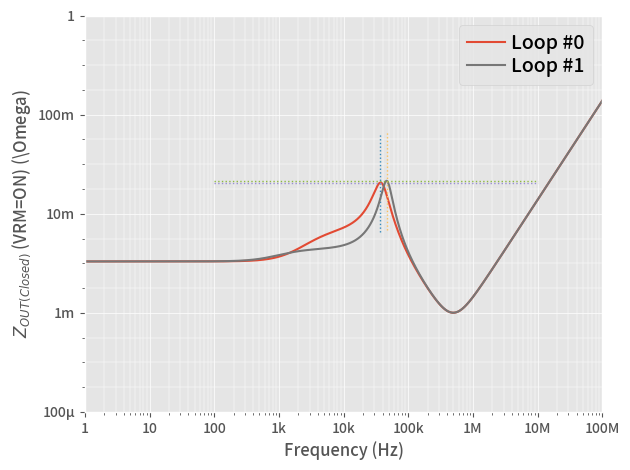

In [7]:
plt.close('all')
fig, ax = plt.subplots(tight_layout=True)

for i in [0, 1]:
    df[df.Step == i].plot(ax=ax, x="Freq", y="abs(Zoc)", label=f"Loop #{i}")
    run.PrepFreqImpePlot(ax, "Frequency (Hz)", r"$Z_{OUT(Closed)}$ (VRM=ON) (\Omega)", "auto", [-80,0])

    tmp = para.loc[i, 'ZMAX']
    ax.plot([para.loc[i,"fZMAX"], para.loc[i,"fZMAX"]], [tmp-10,tmp+10], linewidth=1, linestyle="dotted")
    ax.plot([100,1e7], [tmp, tmp], linewidth=1, linestyle='dotted')

plt.legend(ncol=1, loc="upper right",fancybox=True)
plt.savefig("PltZoP.png", format='png', bbox_inches='tight')

plt.show()


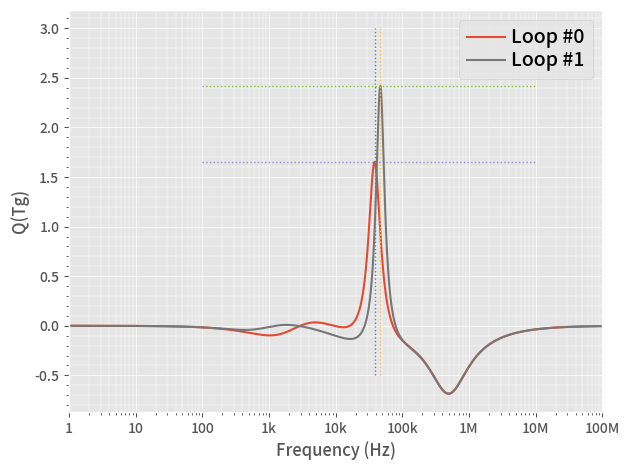

In [8]:
plt.close('all')
plt.style.use('ggplot')
fig, ax = plt.subplots(tight_layout=True)

for i in [0, 1]:
    dfQ[dfQ.Step == i].plot(ax=ax, x="fQTg",  y="QTg", label=f"Loop #{i}")
    run.PrepFreqGainPlot(ax, "Frequency (Hz)", "Q(Tg)", "auto")

    ax.plot([para.loc[i,"fQTgMAX"], para.loc[i,"fQTgMAX"]], [-0.5,3], linewidth=1, linestyle="dotted")
    #ax.plot([0.9 * para.loc[i, 'fQTgMAX'], 1.1 * para.loc[i, 'fQTgMAX']], [para.loc[i,'QTgMAX'], para.loc[i, 'QTgMAX']], linewidth=1, linestyle='dotted')
    ax.plot([100,1e7], [para.loc[i,'QTgMAX'], para.loc[i, 'QTgMAX']], linewidth=1, linestyle='dotted')

plt.legend(ncol=1, loc="upper right",fancybox=True)
plt.savefig("PltQTg.png", format='png', bbox_inches='tight')

plt.show()


## 6. NISM, Calculating Phase-Margin from Output Impedance

In [9]:
import shutil

if nism := shutil.which("nism.exe"):
    print(f"             Phase Margin")
    print(f"           Bode Plot   NISM")
    for i in [0, 1]:
        pm_nism = subprocess.check_output( \
            ["nism.exe", f"{para.loc[i,'fZMAX']}", f"{para.loc[i, 'fQTgMAX']}", f"{para.loc[i, 'QTgMAX']}"])
        print(f"Loop #{i}: {para.loc[i, 'pm']:>8.1f}, {float(pm_nism.decode()):>8.1f}")
else:
    subprocess.run(["explorer.exe","dl.html"])


             Phase Margin
           Bode Plot   NISM
Loop #0:     29.3,     31.5
Loop #1:     22.3,     22.4
